In [1]:
import numpy as np
import matplotlib.pyplot as plot
import skimage.io as io

In [2]:
#Task 1
def basis_images(basis, N):
    transform = np.array(np.zeros((N,N,N*(N+1))), dtype=complex)
    if basis == 'fourier':
        for a in range(0, N):
            for b in range(0, N):
                for x in range(0, N):
                    for y in range(0, N):
                        transform[y, x, N*b+a] = np.exp(-2j*np.pi*(x*a/N+y*b/N)); 
    
    if basis == 'standard':
        for a in range(0, N):
            for b in range(0, N):
                for x in range(0, N):
                    for y in range(0, N):
                        transform[y, x, N*b+a] = int(x==a and y==b)
    
    if basis == 'hartley':
        for a in range(0, N):
            for b in range(0, N):
                for x in range(0, N):
                    for y in range(0, N):
                        transform[y, x, N*b+a] = (
                            1/np.sqrt(N)*(np.cos(2*np.pi*a*x/N)+np.sin(2*np.pi*a*x/N))* #cas function
                            1/np.sqrt(N)*(np.cos(2*np.pi*b*y/N)+np.sin(2*np.pi*b*y/N))
                        )

    if basis == 'sin':
        for a in range(1, N+1):
            for b in range(1, N+1):
                for x in range(1, N+1):
                    for y in range(1, N+1):
                        transform[y-1, x-1, N*(a-1)+(b-1)] = (
                            2/(N+1)*
                            np.sin(x*b*np.pi/(N+1))* #rewrite
                            np.sin(y*a*np.pi/(N+1))
                        )
                        
    if basis == 'cos':
        for a in range(0, N):
            for b in range(0, N):
                for x in range(0, N):
                    for y in range(0, N):
                        a_i, a_j = np.sqrt(2/N), np.sqrt(2/N);
                        if b == 0:
                            a_j = np.sqrt(1/N)
                        if a == 0:
                            a_i = np.sqrt(1/N)
                            
                        transform[y, x, N*a+b] = (
                            a_i*a_j*
                            np.cos( ((2*x+1)*b*np.pi)/(2*N))* 
                            np.cos(((2*y+1)*a*np.pi)/(2*N) )
                        )
    
    
    fig = plot.figure(figsize=(10,10)) 
    
    if basis == 'fourier': plot.title("{0}{1}.png".format(basis, '_real'))
    else: plot.title(basis)
        
    for ind in range(0, N*(N+1)):
        if ind >= N*N: break
        img = np.real(transform[:,:,ind])
        fig.add_subplot(N, N, ind+1)
        plot.gray()
        plot.imshow(img)
        plot.axis('off')
        
    if basis == 'fourier': fig.savefig("{0}{1}.png".format(basis, '_real'), dpi=fig.dpi)
    else: fig.savefig("{}.png".format(basis), dpi=fig.dpi)
    
    if basis == 'fourier':
        fig = plot.figure(figsize=(10,10)) 
        plot.title("{0}{1}.png".format(basis, '_imag'))
        for ind in range(0, N*(N+1)):
            if ind >= N*N: break
            img = np.imag(transform[:,:,ind])
            fig.add_subplot(N, N, ind+1)
            plot.gray()
            plot.imshow(img)
            plot.axis('off')
        fig.savefig("{0}{1}.png".format(basis, '_imag'), dpi=fig.dpi)

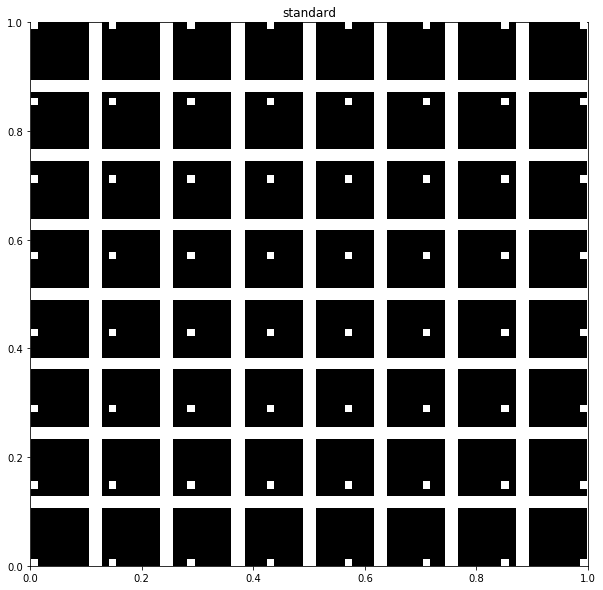

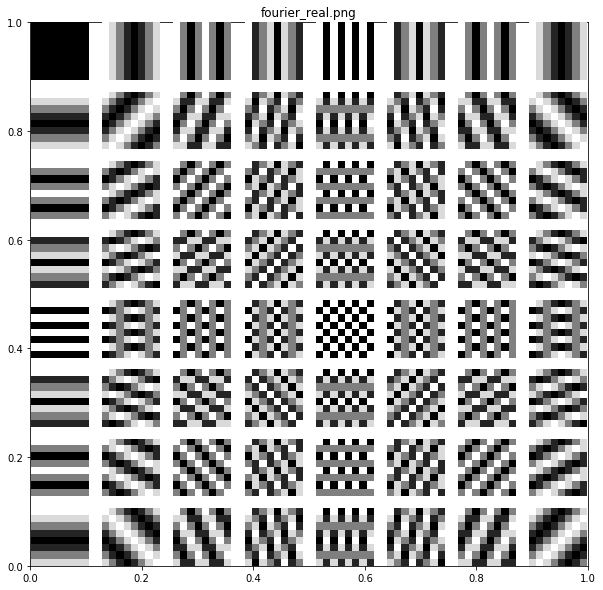

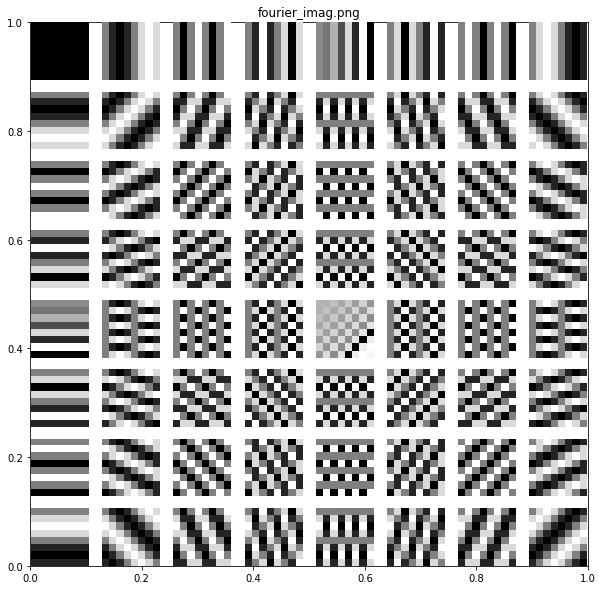

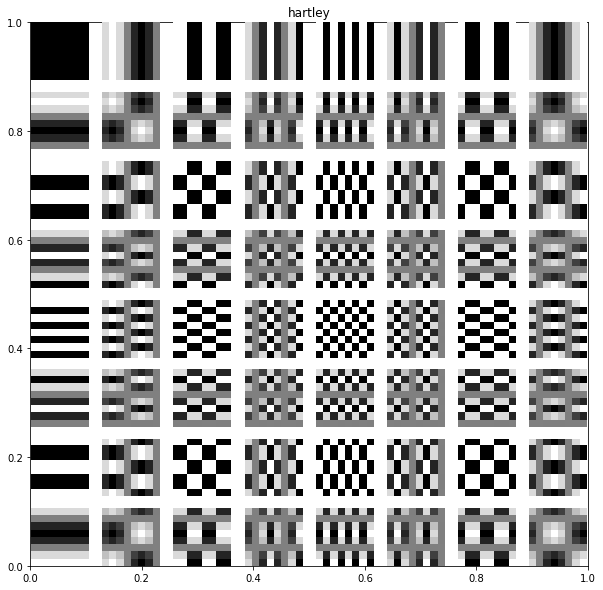

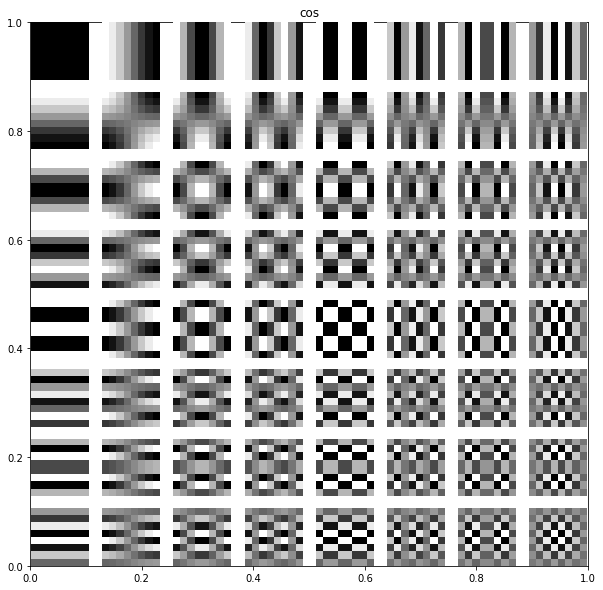

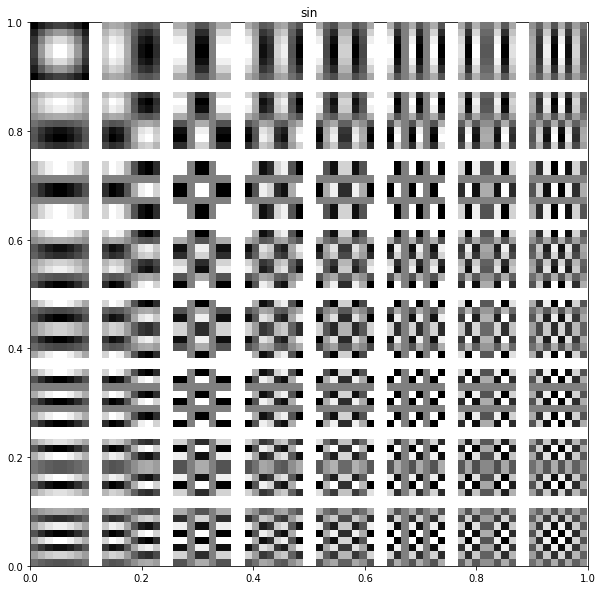

In [3]:
N = 8
basis_images('standard', N)
basis_images('fourier', N)
basis_images('hartley', N)
basis_images('cos', N)
basis_images('sin', N)

In [4]:
#Task 2

#https://www.paulinternet.nl/?page=bicubic
def cubic_interpolator(p0, p1, p2, p3, x):
    return (p1 + 
            0.5*x*(p2-p0+
            x*(2.0*p0-5.0*p1+4.0*p2-p3)+
            x*(3.0*(p1-p2)+p3-p0)))

def transform(img, mode, args):
    if mode == 'horizontal':
        delta = args[0]
        img_modified = np.ones(img.shape)
        for column in range(0, img.shape[0]):
            for row in range(0, img.shape[1]):
                if args[1] == 'linear':
                    if np.abs(args[0]) < 1.0:
                        if int(row+delta) < img.shape[1] and int(row+delta-2*args[0]) > 0:
                                img_modified[column][row] = (
                                    img[column][int(row+delta)]+
                                    img[column][int(row+delta-2*args[0])])*0.5
                    elif 0 < int(row+delta) < img.shape[1]:
                            img_modified[column][row] = img[column][int(row+delta)]
                            
                elif args[1] == 'nearest neighbour':
                    if np.abs(args[0]) < 1.0:
                        if 0 <= int(np.round(row+delta)) < img.shape[1]:
                                img_modified[column][row] = img[column][int(np.round(row+delta))]
                    elif 0 < int(row+delta) < img.shape[1]:
                            img_modified[column][row] = img[column][int(row+delta)]
                            
                            
                elif args[1] == 'cubic':
                    if np.abs(args[0]) < 1.0:
                        if 0 <= int(row+delta) < img.shape[1]:
                            try:
                                x = int(row+delta)
                                y = column
                                p0 = img[y][x]
                                p1 = img[y][x+1]
                                p2 = img[y+1][x]
                                p3 = img[y][x-1]
                                p4 = img[y-1][x]
                                img_modified[column][row] = cubic_interpolator(p1, p2, p3, p4, p0)
                            except:
                               pass
                        
                    elif 0 < int(row+delta) < img.shape[1]:
                            img_modified[column][row] = img[column][int(row+delta)]
            delta+=args[0]   
        return img_modified
            
    if mode == 'rotate':
        #x shear -tan(phi*0.5)
        phi = args[0]
        xshear = -np.tan(phi*0.5)
        yshear = np.sin(phi)
        xdelta = xshear
        ydelta = yshear
        
        img_modified = np.ones(img.shape)
        for column in range(0, img.shape[0]):
            for row in range(0, img.shape[1]):
                if args[1] == 'linear':
                    if np.abs(xshear) < 1.0:
                        if 0 <= int(row+xdelta) < img.shape[0] and int(row+xdelta-2*args[0]) > 0:
                                img_modified[column][row] = (
                                    img[column][int(row+xdelta)]+
                                    img[column][int(row+xdelta-2*xshear)])*0.5

                    elif 0 <= int(row+xdelta) < img.shape[0]:
                        img_modified[column][row] = img[column][int(row+xdelta)]
                        
                elif args[1] == 'nearest neighbour':
                    if np.abs(args[0]) < 1.0:
                        if 0 <= int(np.round(row+xdelta)) < img.shape[1]:
                                img_modified[column][row] = img[column][int(np.round(row+xdelta))]
                    elif 0 < int(row+xdelta) < img.shape[1]:
                            img_modified[column][row] = img[column][int(row+xdelta)]
            xdelta += xshear

        #y shear sin(phi)
        img_modified2 = np.ones(img.shape)
        for row in range(0, img.shape[1]):
            for column in range(0, img.shape[0]):
                if args[1] == 'linear':
                    if np.abs(yshear) < 1.0:
                        if 0 <= int(column+ydelta) < img.shape[1] and int(column+ydelta-2*args[0]) > 0:
                                img_modified2[column][row] = (
                                    img_modified[int(column+ydelta)][row]+
                                    img_modified[int(column+ydelta-2*args[0])][row])*0.5
                                
                    elif  0<= int(column+ydelta) < img.shape[1]:
                        img_modified2[column][row] = img_modified[int(column+ydelta)][row]
                        
                elif args[1] == 'nearest neighbour':
                    if np.abs(args[0]) < 1.0:
                        if 0 <= int(np.round(column+ydelta)) < img.shape[1]:
                                img_modified2[column][row] = img_modified[int(np.round(column+ydelta))][row]
                    elif 0 < int(column+ydelta) < img.shape[1]:
                            img_modified2[column][row] = img_modified[int(column+ydelta)][row]
            ydelta += yshear
            
        xdelta = xshear
        #x shear -tan(phi*0.5)
        img_modified3 = np.ones(img.shape)
        for column in range(0, img.shape[0]):
            for row in range(0, img.shape[1]):
                if args[1] == 'linear':
                    if np.abs(xshear) < 1.0:
                        if 0<= int(row+xdelta) < img.shape[0] and int(row+xdelta-2*args[0]) > 0:
                                img_modified3[column][row] = (
                                    img_modified2[column][int(row+xdelta)]+
                                    img_modified2[column][int(row+xdelta-2*xshear)])*0.5

                    elif 0 <= int(row+xdelta) < img.shape[0]:
                        img_modified3[column][row] = img_modified2[column][int(row+xdelta)]
                        
                elif args[1] == 'nearest neighbour':
                    if np.abs(args[0]) < 1.0:
                        if 0 <= int(np.round(row+xdelta)) < img.shape[1]:
                                img_modified3[column][row] = img_modified2[column][int(np.round(row+xdelta))]
                    elif 0 < int(row+xdelta) < img.shape[1]:
                            img_modified3[column][row] = img_modified2[column][int(row+xdelta)]
            xdelta += xshear
        
        return img_modified3
    

(-0.5, 719.5, 719.5, -0.5)

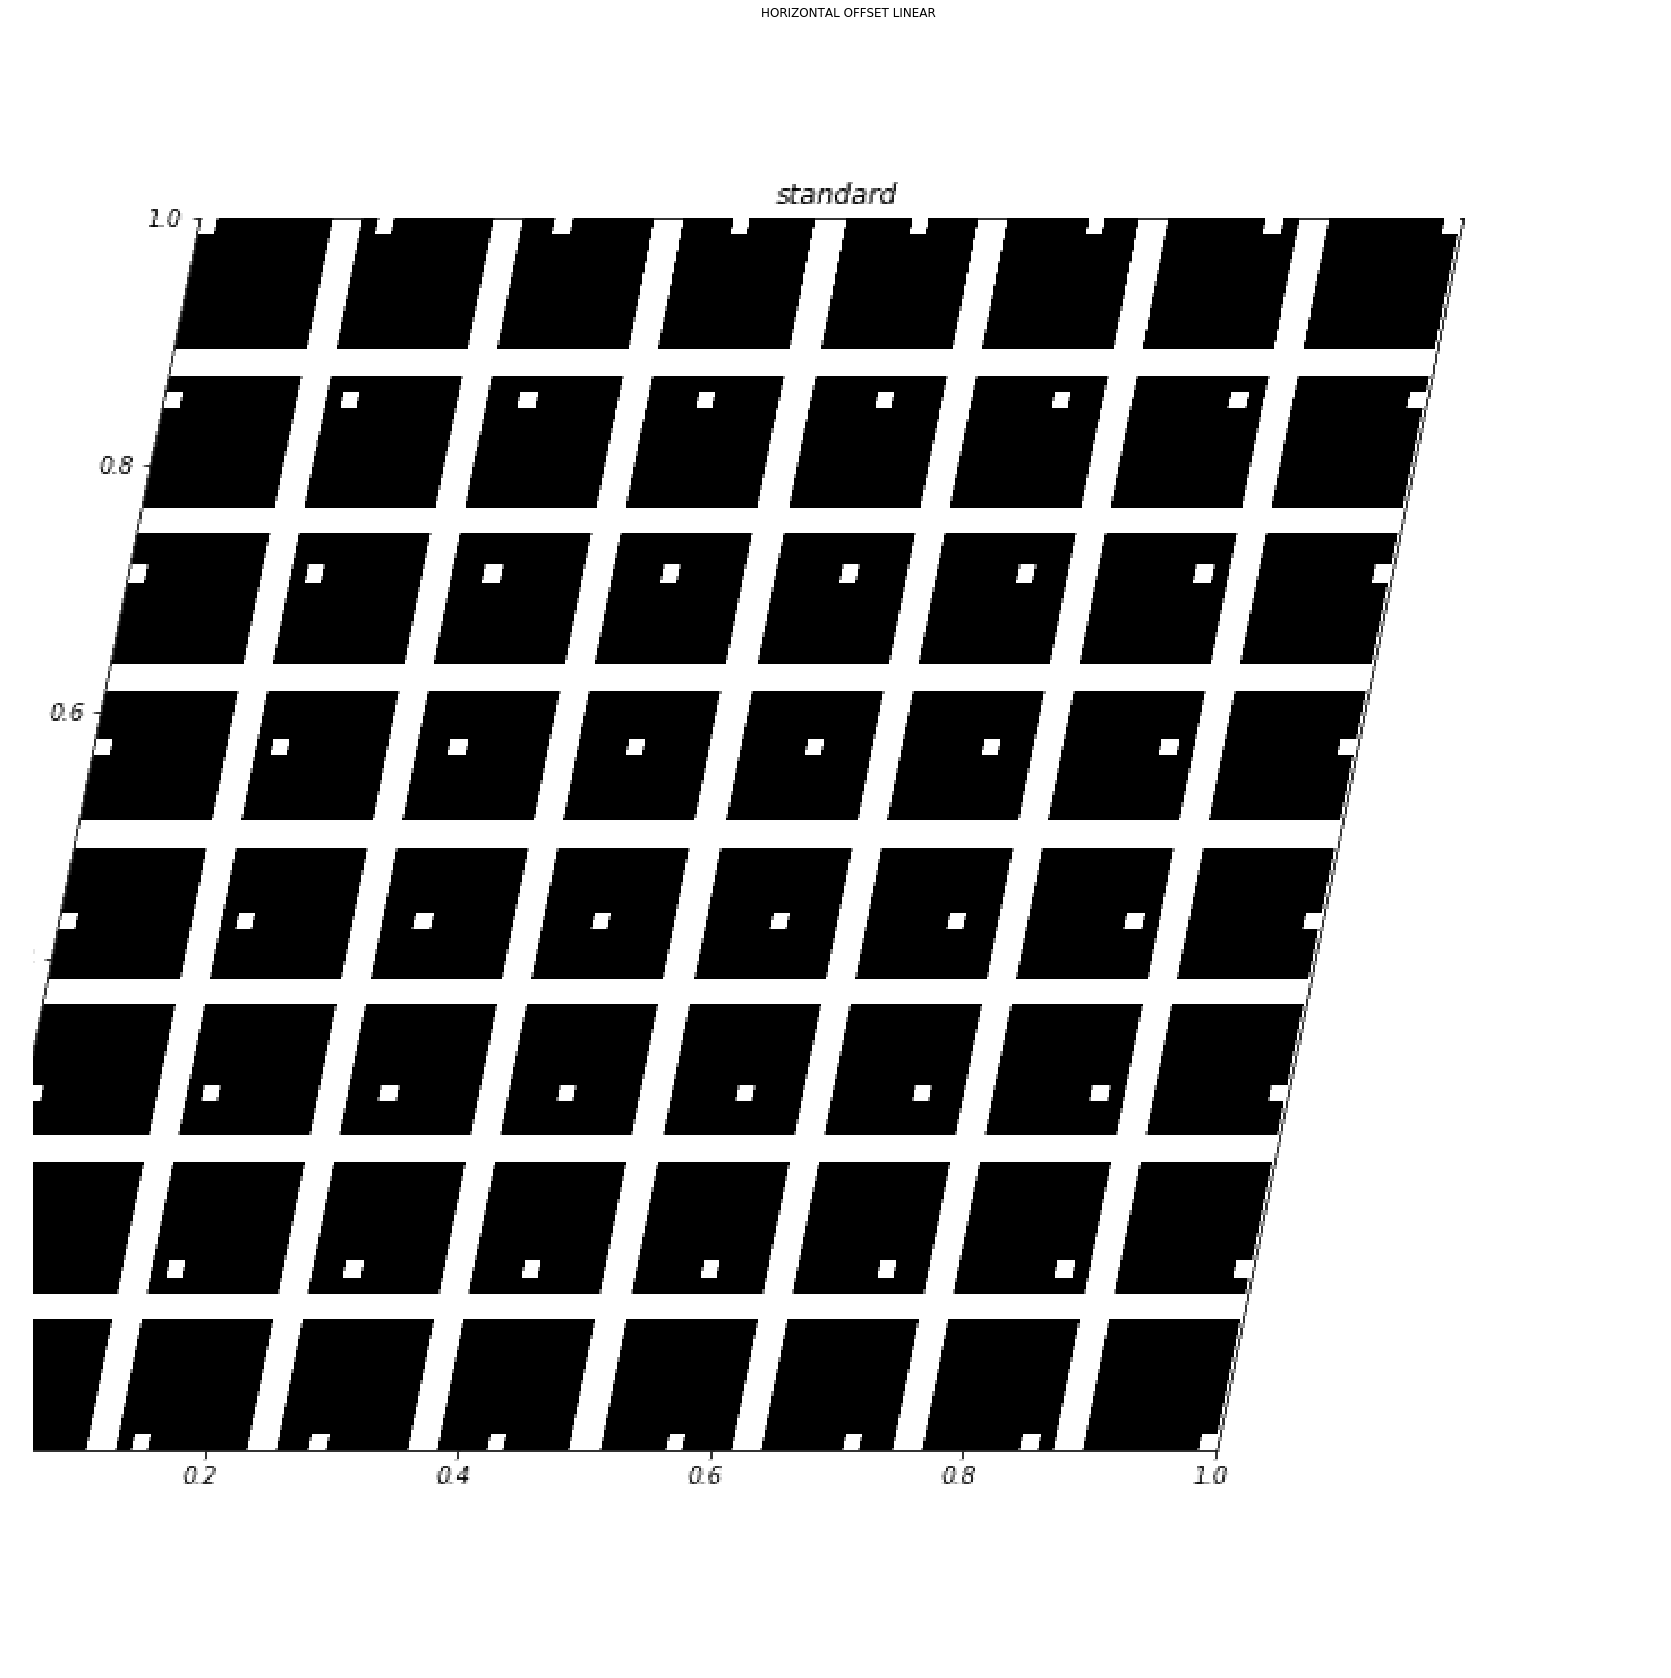

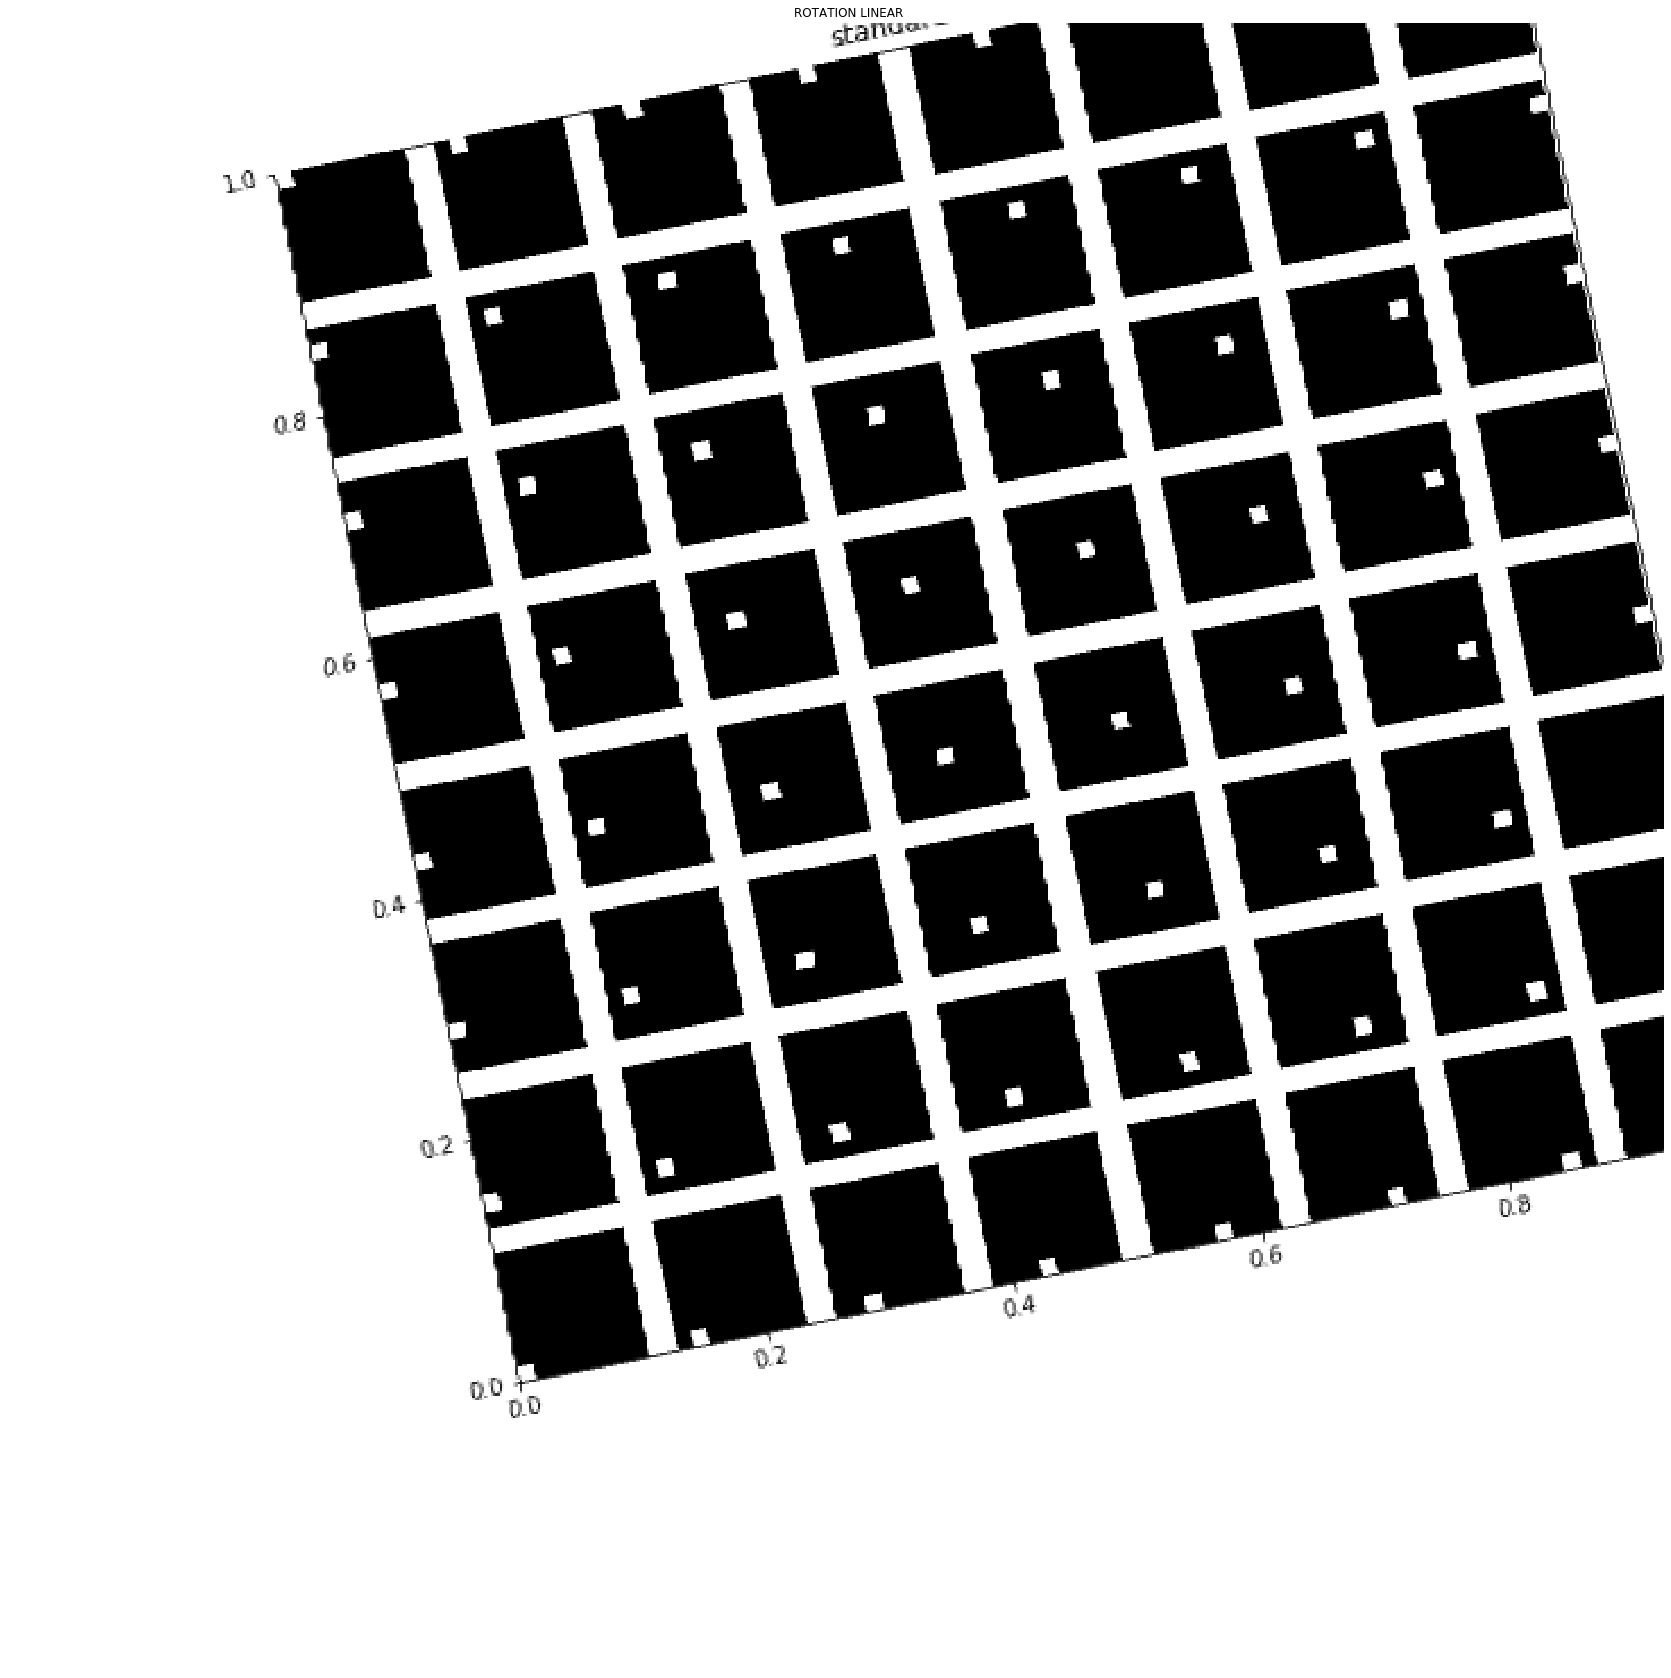

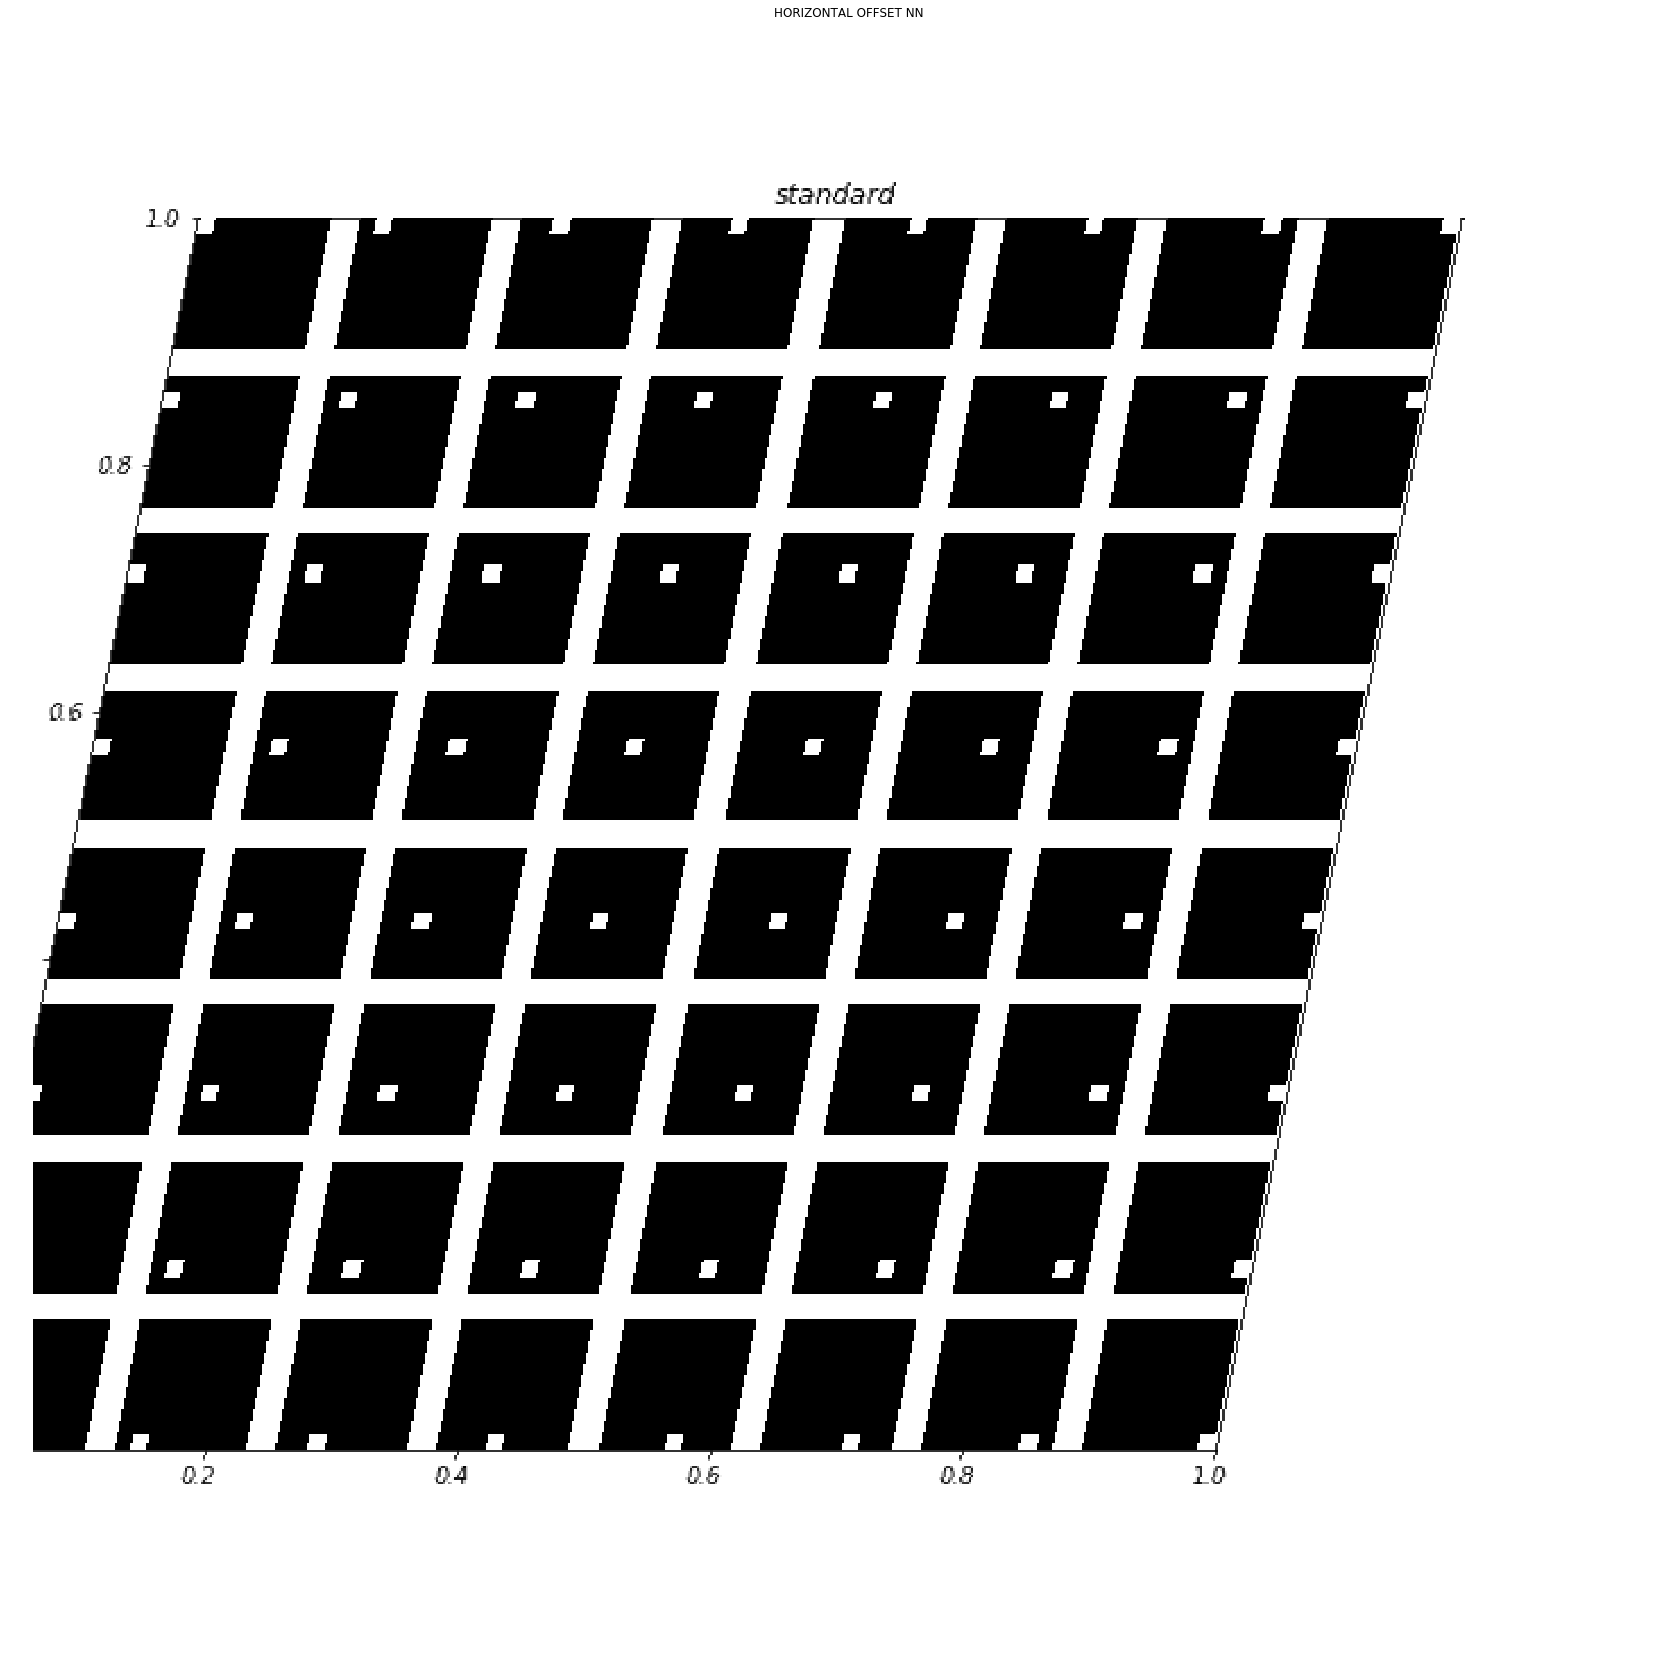

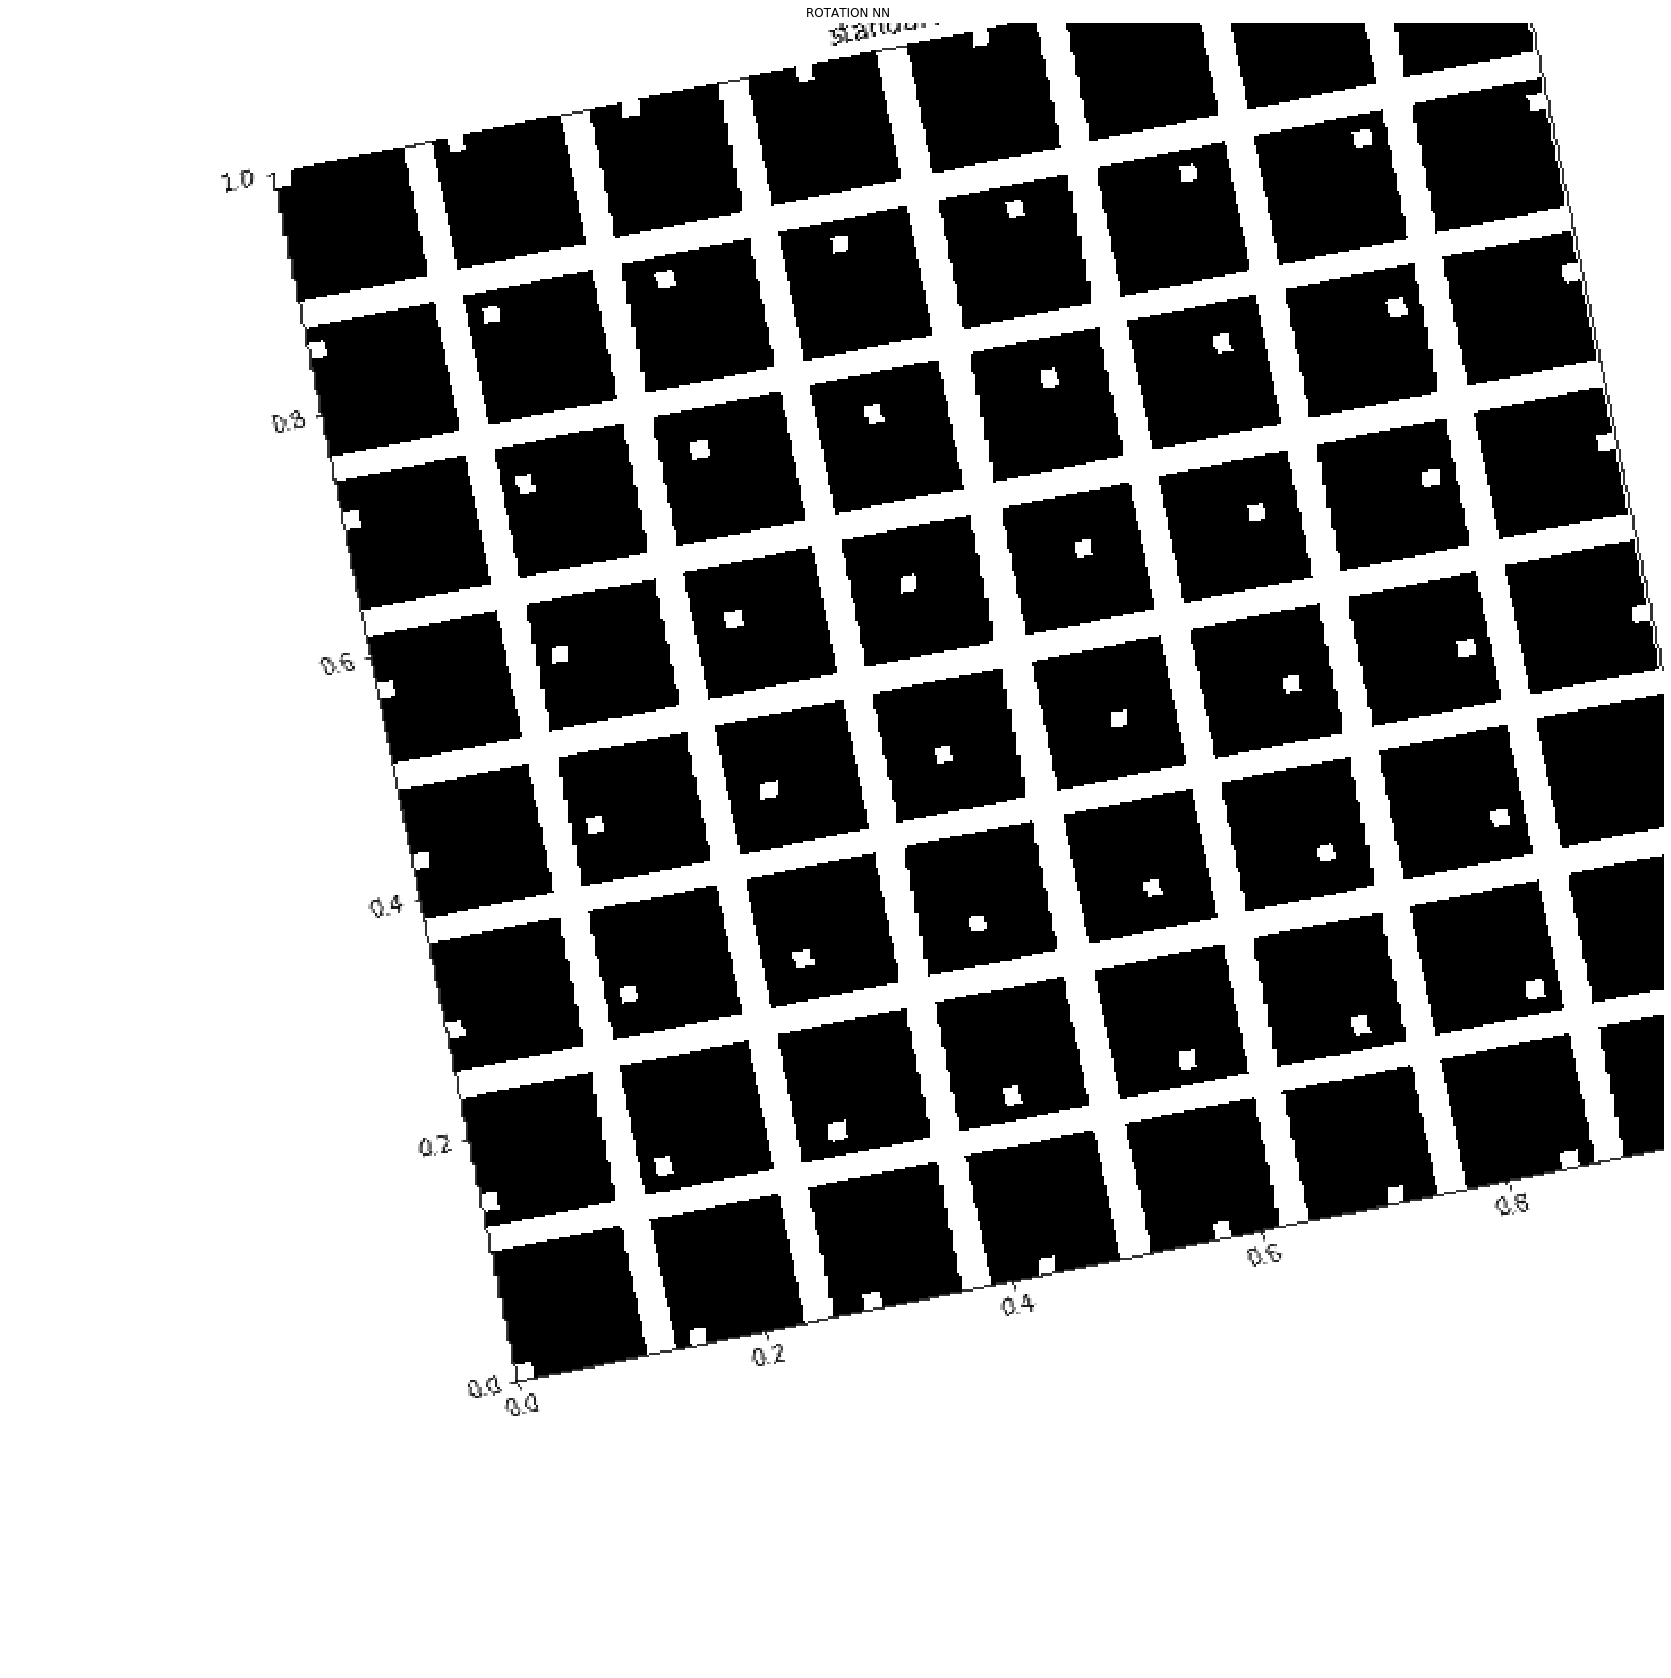

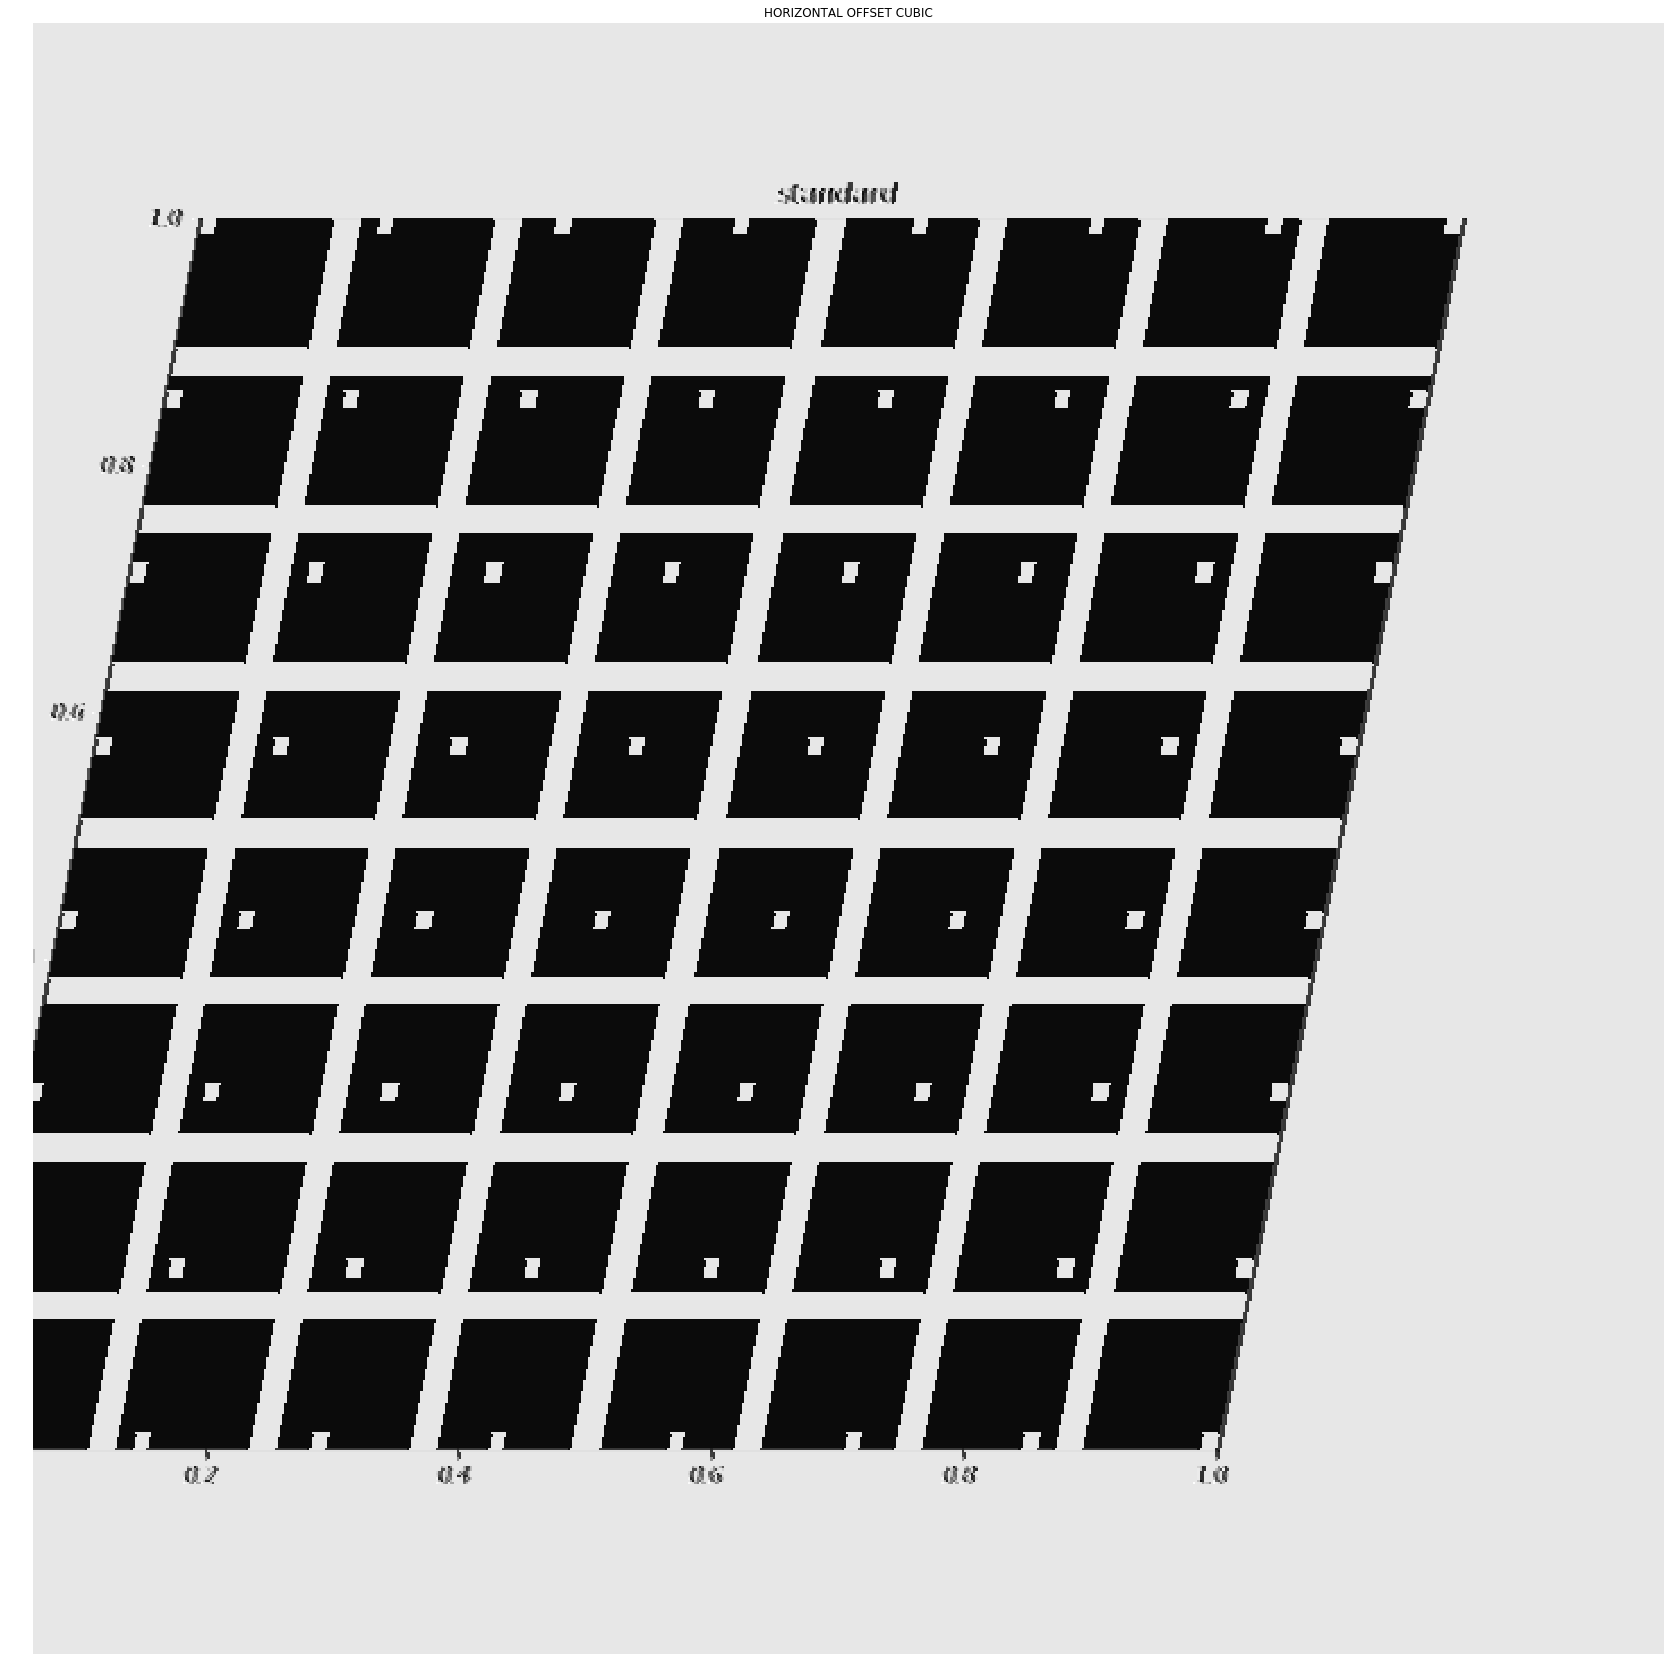

In [5]:

img = io.imread('standard.png', as_gray = True) #use one of the images generated in task 1
img = transform(img, 'horizontal', [0.2, 'linear'])
fig = plot.figure(figsize=(30,30)) 
plot.title('HORIZONTAL OFFSET LINEAR')
plot.gray()
plot.imshow(img)
plot.axis('off')
        
    
img = io.imread('standard.png', as_gray = True) #use one of the images generated in task 1
img = transform(img, 'rotate', [0.2, 'linear'])
fig = plot.figure(figsize=(30,30)) 
plot.title('ROTATION LINEAR')
plot.gray()
plot.imshow(img)
plot.axis('off')
        
    
img = io.imread('standard.png', as_gray = True) #use one of the images generated in task 1
img = transform(img, 'horizontal', [0.2, 'nearest neighbour'])
fig = plot.figure(figsize=(30,30)) 
plot.title('HORIZONTAL OFFSET NN')
plot.gray()
plot.imshow(img)
plot.axis('off')
        
    
img = io.imread('standard.png', as_gray = True) #use one of the images generated in task 1
img = transform(img, 'rotate', [0.2, 'nearest neighbour'])
fig = plot.figure(figsize=(30,30)) 
plot.title('ROTATION NN')
plot.gray()
plot.imshow(img)
plot.axis('off')

img = io.imread('standard.png', as_gray = True) #use one of the images generated in task 1
img = transform(img, 'horizontal', [0.2, 'cubic'])
fig = plot.figure(figsize=(30,30)) 
plot.title('HORIZONTAL OFFSET CUBIC')
plot.gray()
plot.imshow(img)
plot.axis('off')
        
        